In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound

In [22]:
help(fminbound)

Help on function fminbound in module scipy.optimize.optimize:

fminbound(func, x1, x2, args=(), xtol=1e-05, maxfun=500, full_output=0, disp=1)
    Bounded minimization for scalar functions.
    
    Parameters
    ----------
    func : callable f(x,*args)
        Objective function to be minimized (must accept and return scalars).
    x1, x2 : float or array scalar
        The optimization bounds.
    args : tuple, optional
        Extra arguments passed to function.
    xtol : float, optional
        The convergence tolerance.
    maxfun : int, optional
        Maximum number of function evaluations allowed.
    full_output : bool, optional
        If True, return optional outputs.
    disp : int, optional
        If non-zero, print messages.
            0 : no message printing.
            1 : non-convergence notification messages only.
            2 : print a message on convergence too.
            3 : print iteration results.
    
    
    Returns
    -------
    xopt : ndarray
   

# Interpolation

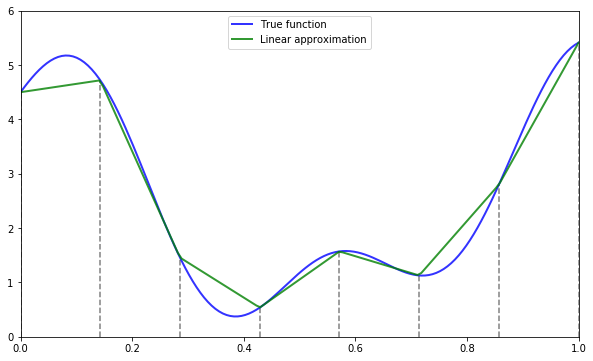

In [20]:
# target function
def f(x):
    y1 = 2*np.cos(6*x) + np.sin(14*x)
    return y1+2.5

c_grid = np.linspace(0,1,8)

# interpolation
def Af(x):
    return np.interp(x, c_grid, f(c_grid))

f_grid = np.linspace(0,1,150)

fig, ax = plt.subplots(figsize=(10,6))

ax.set(xlim=(0,1), ylim=(0,6))
ax.plot(f_grid, f(f_grid), 'b-', lw=2, alpha=0.8, label='True function')
ax.plot(f_grid, Af(f_grid), 'g-', lw=2, alpha=0.8, label='Linear approximation')
ax.vlines(c_grid, c_grid*0, f(c_grid), linestyles='dashed', alpha=0.5)

ax.legend(loc='upper center')

plt.show()

# Bellman operator

In [61]:
def bellman_operator(w, grid, β, u, f, shocks, Tw=None, compute_policy=False):
    # w - the value of the input function on different grid points
    # u - utility function
    # f - production function
    
    # linear approximation of w
    w_func = lambda x: np.interp(x, grid, w)
    
    if Tw is None:
        Tw = np.empty_like(w)
        
    if compute_policy:
        σ = np.empty_like(w)
        
    for i, y in enumerate(grid):
        def objective(c):
            return -u(c)-β*np.mean(w_func(f(y-c)*shocks))
        
        c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            σ[i]=c_star
            
        Tw[i]=-objective(c_star)
        
    if compute_policy:
        return Tw, σ
    else:
        return Tw

# Log-linear optimal growth

In [23]:
class LogLinearOG:
    
    def __init__(self, α=0.4, β=0.96, μ=0, s=0.1):
        self.α, self.β, self.μ, self.s = α, β, μ, s
        
        self.ab = α*β
        self.c1 = np.log(1-self.ab)/(1-β)
        self.c2 = (μ+α*np.log(self.ab))/(1-α)
        self.c3 = 1/(1-β)
        self.c4 = 1/(1-self.ab)
    
    # utility function
    def u(self, c):
        return np.log(c)
    
    def u_prime(self, c):
        return 1/c
    
    # production function
    def f(self, k):
        return k**self.α
    
    def f_prime(self, k):
        return self.α*k**(α-1)
    
    # optimal policy
    def c_star(self, y):
        return (1-self.α*self.β)*y
    
    # final value function
    def v_star(self, y):
        return self.c1 + self.c2 * (self.c3-self.c4) + self.c4*np.log(y)

# Implementation of log-linear model

### first shot

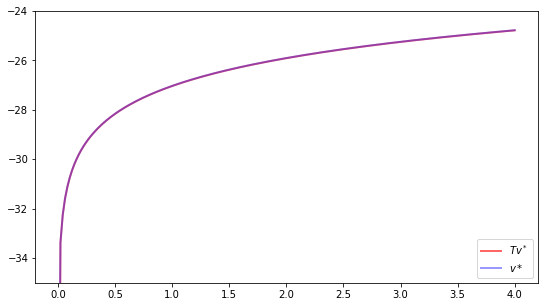

In [62]:
lg = LogLinearOG()
α, β, μ, s = lg.α, lg.β, lg.μ, lg.s
v_star = lg.v_star

grid_max = 4
grid_size = 200
shock_size = 250

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(μ + s*np.random.randn(shock_size))

w = bellman_operator(v_star(grid), grid, β, np.log, lambda k: k**α, shocks)

fig, ax =plt.subplots(figsize=(9,5))
ax.set_ylim(-35, -24)
ax.plot(grid, w, 'r-', lw=2, alpha=0.6, label='$Tv^*$')
ax.plot(grid, v_star(grid), 'b-', lw=2, alpha=0.4, label='$v*$')
ax.legend(loc=4)

plt.show()

### defined number of iterations

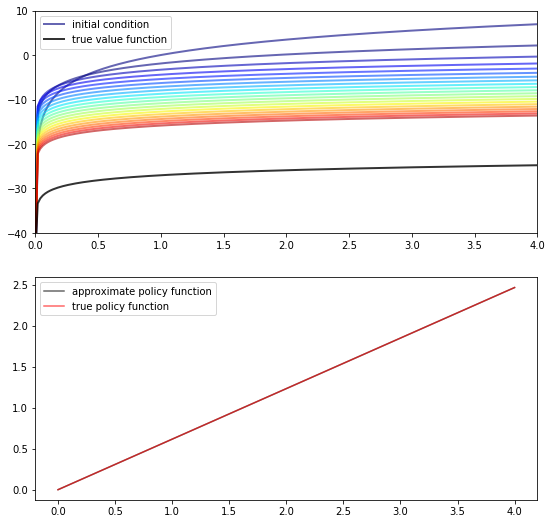

In [80]:
# initial guess: w(y) = 5 ln(y)
w = 5*np.log(grid)
# w = np.zeros(200)
n=20

fig, (ax, ax2) = plt.subplots(2,1,figsize=(9,9))
ax.set_ylim(-40,10)
ax.set_xlim(np.min(grid), np.max(grid))

lb = 'initial condition'
ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)

for i in range(n):
    w, σ = bellman_operator(w, grid, β, np.log, lambda k: k**α, shocks, compute_policy=True)
    ax.plot(grid, w, color=plt.cm.jet(i/n), lw=2, alpha=0.6)
    
lb = 'true value function'
ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)

ax.legend()

ax2.plot(grid, σ, 'k-', alpha=0.6, label='approximate policy function')
cstar = (1 - α * β) * grid
ax2.plot(grid, cstar, 'r-', alpha=0.6, label='true policy function')
ax2.legend()

plt.show()

### with while loop

340


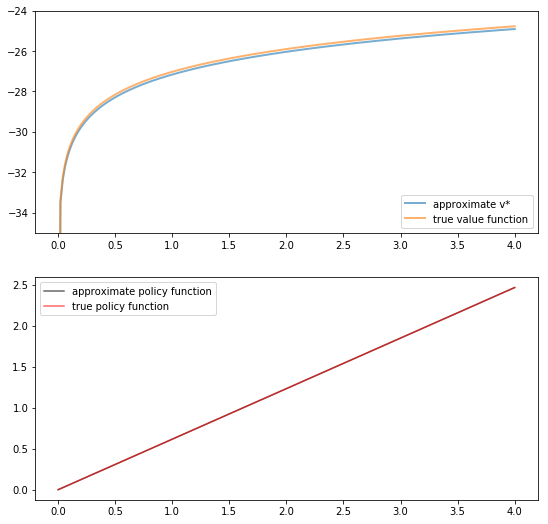

In [81]:
def solve_optimal_growth(initial_w, tol=1e-6, max_iter=500):
    w = initial_w
    error = tol+1
    i=0
    
    Tw  = np.empty(len(grid))
    
    while error>tol and i<max_iter:
        w_new = bellman_operator(w, grid, β, np.log, lambda k: k**α, shocks)
        error = np.max(np.abs(w_new-w))
        w[:] = w_new
        i+=1
    print(i)
    return w

initial_w = 5*np.log(grid)

fig, (ax, ax2) = plt.subplots(2,1,figsize=(9,9))
ax.set_ylim(-35, -24)
ax.plot(grid, solve_optimal_growth(initial_w), lw=2, alpha=0.6, label='approximate v*')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='true value function')
ax.legend(loc=4)

ax2.plot(grid, σ, 'k-', alpha=0.6, label='approximate policy function')
cstar = (1 - α * β) * grid
ax2.plot(grid, cstar, 'r-', alpha=0.6, label='true policy function')
ax2.legend()

plt.show()